In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.2"
export JULIA_PACKAGES="CUDA IJulia CairoMakie"
JULIA_NUM_THREADS="2"
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  echo "Installing Julia packages, this may take up to 15 minutes. "
  julia -e 'using Pkg; Pkg.add(["CUDA", "IJulia", "CairoMakie"]); Pkg.add(Pkg.PackageSpec(url="https://github.com/FluxML/FastAI.jl")); Pkg.precompile()' &> /dev/null

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Please reload this page and jump to the next section."
fi

Installing Julia 1.6.2 on the current Colab Runtime...
2021-11-29 14:54:50 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.2-linux-x86_64.tar.gz [112946671/112946671] -> "/tmp/julia.tar.gz" [1]
Installing Julia packages, this may take up to 15 minutes. 
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.6

Success! Please reload this page and jump to the next section.


In [1]:
using Statistics
using Flux, Flux.Optimise
using MLDatasets: CIFAR10
using Images.ImageCore
using Flux: onehotbatch, onecold
using Base.Iterators: partition
# using CUDA

In [2]:
train_x, train_y = CIFAR10.traindata(Float32)
labels = onehotbatch(train_y, 0:9)

println(size(train_x), size(labels))

(32, 32, 3, 50000)(10, 50000)


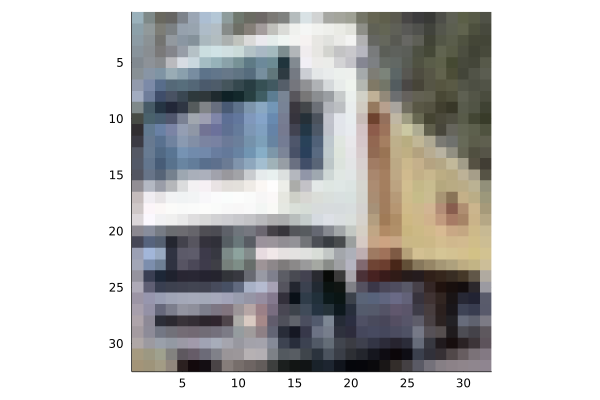

In [9]:
using Plots

image(x) = colorview(RGB, permutedims(x, (3, 2, 1)))
plot(image(train_x[:, :, :, 2]))

In [11]:
train = ([(train_x[:,:,:,i], labels[:,i]) for i in partition(1:49000, 1000)]) |> gpu
valset = 49001:50000
valX = train_x[:,:,:,valset] |> gpu
valY = labels[:, valset] |> gpu

10×1000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

In [12]:
m = Chain(
  Conv((5,5), 3=>16, relu),
  MaxPool((2,2)),
  Conv((5,5), 16=>8, relu),
  MaxPool((2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(200, 120),
  Dense(120, 84),
  Dense(84, 10),
  softmax) |> gpu

Chain(
  Conv((5, 5), 3 => 16, relu),          # 1_216 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 16 => 8, relu),          # 3_208 parameters
  MaxPool((2, 2)),
  var"#5#6"(),
  Dense(200 => 120),                    # 24_120 parameters
  Dense(120 => 84),                     # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 39_558 parameters, 155.852 KiB.

In [13]:
using Flux: crossentropy, Momentum

loss(x, y) = sum(crossentropy(m(x), y))
opt = Momentum(0.01)

Momentum(0.01, 0.9, IdDict{Any, Any}())

In [14]:
accuracy(x, y) = mean(onecold(m(x), 0:9) .== onecold(y, 0:9))


accuracy (generic function with 1 method)